In [27]:
from fastapi import FastAPI
import pandas as pd
import numpy as np
import pickle


from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings("ignore")

In [2]:
aws = pd.read_csv("./../FANNG_stock_price_8_4_25/AMAZON_daily.csv")
aws.Date = pd.to_datetime(aws.Date)
aws.set_index('Date', inplace=True)


In [3]:
data = aws.filter(['Close'])


In [4]:
def create_lags(df, lag_days):
    for lag in range(1, lag_days + 1):
        df[f'lag_{lag}'] = df['Close'].shift(lag)
    return df

In [5]:
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .9))

training_data_len

6389

In [6]:


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[1.16223694e-04],
       [6.88705358e-05],
       [6.45687290e-05],
       ...,
       [9.50948448e-01],
       [9.67147443e-01],
       [8.87144203e-01]])

In [7]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([1.16223694e-04, 6.88705358e-05, 6.45687290e-05, 4.95019984e-05,
       6.45480389e-06, 0.00000000e+00, 2.15215344e-05, 3.87412312e-05,
       2.79804640e-05, 2.25959393e-05, 2.15215344e-05, 2.36745007e-05,
       1.72155711e-05, 4.30180684e-06, 3.01293046e-05, 5.38079618e-05,
       6.02627657e-05, 3.87412312e-05, 3.01293046e-05, 4.30430689e-05,
       3.87412312e-05, 3.65882342e-05, 2.25959393e-05, 2.36745007e-05,
       2.36745007e-05, 2.69019026e-05, 2.15215344e-05, 2.36745007e-05,
       2.36745007e-05, 2.36745007e-05, 1.93685374e-05, 3.01293046e-05,
       2.47489364e-05, 3.98156361e-05, 1.06537362e-04, 1.24831495e-04,
       1.87247227e-04, 1.91553190e-04, 2.41055188e-04, 1.85094260e-04,
       1.52811959e-04, 2.15227721e-04, 1.93706187e-04, 1.70031655e-04,
       1.57117922e-04, 1.62498290e-04, 1.52811959e-04, 1.85094260e-04,
       1.78639456e-04, 1.72180527e-04, 1.91553190e-04, 2.23835492e-04,
       2.17380688e-04, 2.06619920e-04, 2.10921758e-04, 1.89400224e-04,
     

In [12]:


# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

6329/6329 ━━━━━━━━━━━━━━━━━━━━ 285s 44ms/step - loss: 0.0010


In [13]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


np.float64(8.49429306906065)

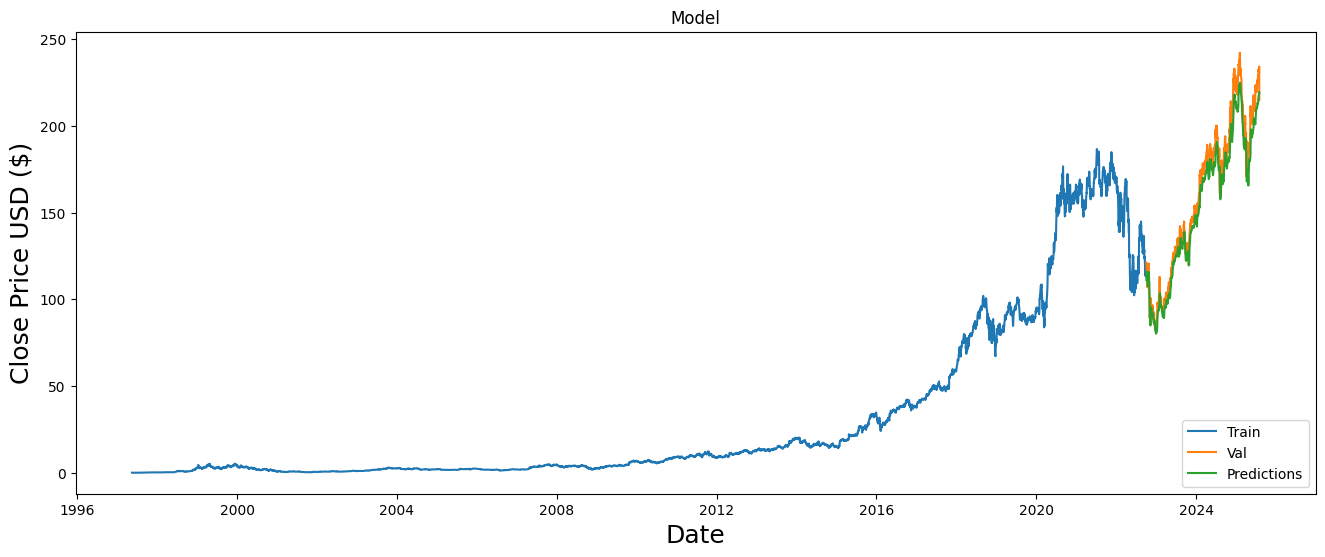

In [14]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

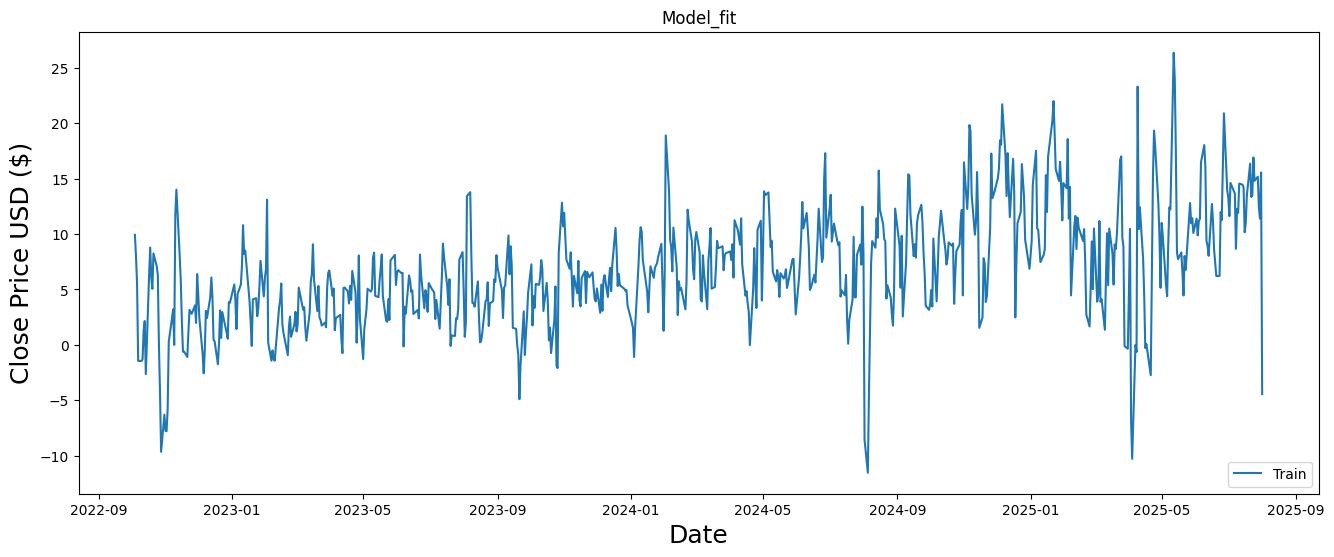

In [15]:

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model_fit')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid['Close'] - valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Predict the difference (delta) to handle consistent bias

In [17]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train_delta = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train_delta.append(train_data[i, 0] - train_data[i-1, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train_delta = np.array(x_train), np.array(y_train_delta)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([1.16223694e-04, 6.88705358e-05, 6.45687290e-05, 4.95019984e-05,
       6.45480389e-06, 0.00000000e+00, 2.15215344e-05, 3.87412312e-05,
       2.79804640e-05, 2.25959393e-05, 2.15215344e-05, 2.36745007e-05,
       1.72155711e-05, 4.30180684e-06, 3.01293046e-05, 5.38079618e-05,
       6.02627657e-05, 3.87412312e-05, 3.01293046e-05, 4.30430689e-05,
       3.87412312e-05, 3.65882342e-05, 2.25959393e-05, 2.36745007e-05,
       2.36745007e-05, 2.69019026e-05, 2.15215344e-05, 2.36745007e-05,
       2.36745007e-05, 2.36745007e-05, 1.93685374e-05, 3.01293046e-05,
       2.47489364e-05, 3.98156361e-05, 1.06537362e-04, 1.24831495e-04,
       1.87247227e-04, 1.91553190e-04, 2.41055188e-04, 1.85094260e-04,
       1.52811959e-04, 2.15227721e-04, 1.93706187e-04, 1.70031655e-04,
       1.57117922e-04, 1.62498290e-04, 1.52811959e-04, 1.85094260e-04,
       1.78639456e-04, 1.72180527e-04, 1.91553190e-04, 2.23835492e-04,
       2.17380688e-04, 2.06619920e-04, 2.10921758e-04, 1.89400224e-04,
     

In [18]:
# Build the LSTM model
modeld = Sequential()
modeld.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
modeld.add(Dropout(0.1))
modeld.add(LSTM(64, return_sequences=False))
modeld.add(Dropout(0.1))
modeld.add(Dense(25))
modeld.add(Dense(1))

# Compile the model
modeld.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
modeld.fit(x_train, y_train_delta, batch_size=1, epochs=1)

6329/6329 ━━━━━━━━━━━━━━━━━━━━ 244s 38ms/step - loss: 5.4715e-05


In [24]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions_delta = modeld.predict(x_test)
predictions_delta = predictions_delta.flatten() + x_test[:, -1, 0]
predictions_delta = predictions_delta.reshape(-1, 1)
predictions_delta = scaler.inverse_transform(predictions_delta)

# Get the root mean squared error (RMSE)
rmse_delta = np.sqrt(np.mean(((predictions_delta - y_test) ** 2)))
rmse_delta

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


np.float64(3.351245791196262)

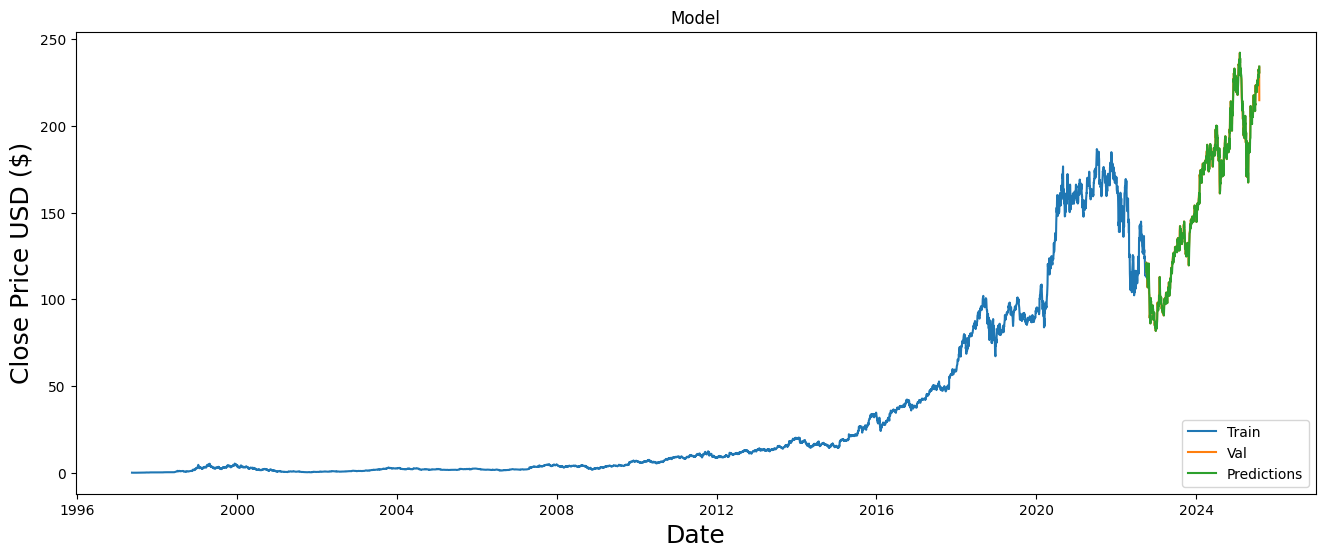

In [25]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions_delta
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

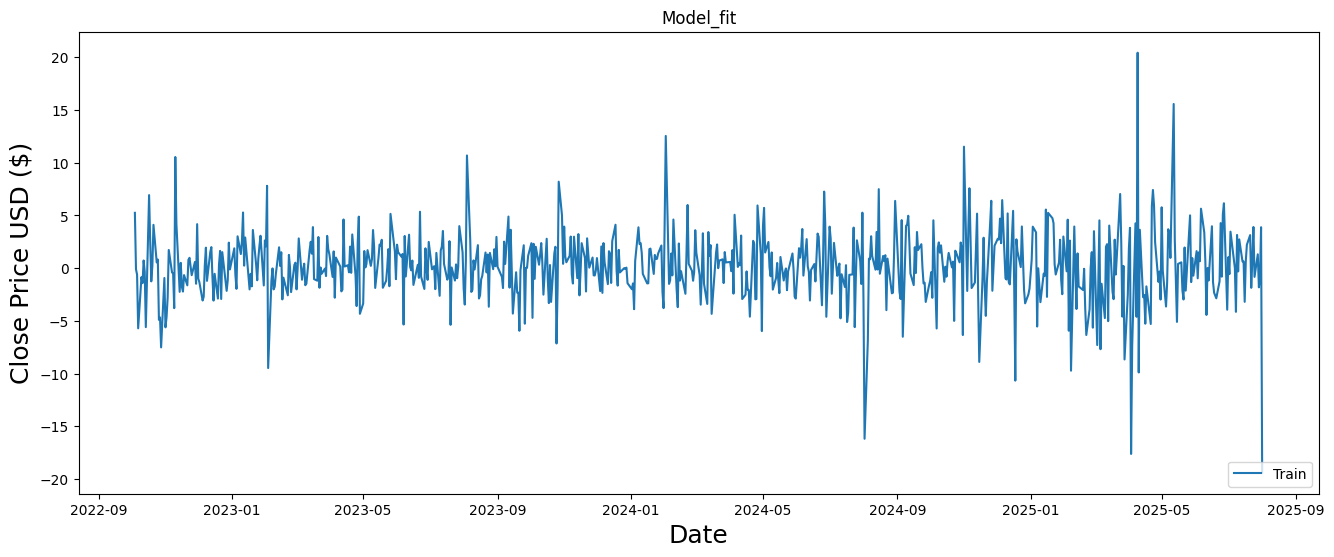

In [26]:

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model_fit')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid['Close'] - valid['Predictions'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
pickle.dump(modeld, open('model/LSTM_delta_AMZ.pkl', 'wb'))

# Conclusion
LSTM perform better when I choose to predict the difference. I have tried to use lightGBM but the performance is bad at recent data points. Adding dropout is also good to prevent overfit.